In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../base')

In [3]:
import munea_core

In [4]:
import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as sd
from tqdm import tqdm_notebook

import munea_core.metrics.cc as cc
import munea_core.metrics.diagnostic as diag
import munea_core.metrics.rank as rank
import munea_core.transformations.destroyer as destroy
from munea_core.network import Layer, Models, MultiLayer
from munea_core.utils import *

In [5]:
def null_mo(multilayer, steps, method, factor, rewire=True, desc=None):
    results = []
    init_dist = method(multilayer)
    for step in tqdm_notebook(range(steps), leave=False, desc=desc):
        destroyer = destroy.Destroyer(multilayer)
        if rewire:
            reduced_multilayer = destroyer.rewire_random_edges_preserving_degree(int(factor * step))
        else:
            reduced_multilayer = destroyer.remove_random_edges(factor * step)

        reduced_dist = method(reduced_multilayer)
        distance = sd.jensenshannon(init_dist, reduced_dist)
        results.append(np.nanmean(distance))
    return results

In [6]:
steps_num = 1000
frac = 0.0005
tries = 1

all_plots = []
all_results = {}

ws_multilayer = MultiLayer(
    Layer(Models.watts_strogatz_graph, n=100, p=0.2, k=5),
    Layer(Models.watts_strogatz_graph, n=100, p=0.2, k=5),
)

er_multilayer = MultiLayer(
    Layer(Models.erdos_renyi_graph, n=100, p=0.2),
    Layer(Models.erdos_renyi_graph, n=100, p=0.2),
)

ba_multilayer = MultiLayer(
    Layer(Models.barabasi_albert_graph, n=100, m=3),
    Layer(Models.barabasi_albert_graph, n=100, m=3),
)

ws_er_multilayer = MultiLayer(
    Layer(Models.watts_strogatz_graph, n=100, p=0.2, k=5),
    Layer(Models.erdos_renyi_graph, n=100, p=0.2),
)

ws_ba_multilayer = MultiLayer(
    Layer(Models.watts_strogatz_graph, n=100, p=0.2, k=5),
    Layer(Models.barabasi_albert_graph, n=100, m=3),
)

er_ba_multilayer = MultiLayer(
    Layer(Models.erdos_renyi_graph, n=100, p=0.2),
    Layer(Models.barabasi_albert_graph, n=100, m=3),
)

multilayers = {
    'WS/Rewire': (ws_multilayer, True, tries),
    'WS/DropEdges': (ws_multilayer, False, frac),
    'ER/Rewire': (er_multilayer, True, tries),
    'ER/DropEdges': (er_multilayer, False, frac),
    'BA/Rewire': (ba_multilayer, True, tries),
    'BA/DropEdges': (ba_multilayer, False, frac),
    'WS-ER/Rewire': (ws_er_multilayer, True, tries),
    'WS-ER/DropEdges': (ws_er_multilayer, False, frac),
    'WS-BA/Rewire': (ws_ba_multilayer, True, tries),
    'WS-BA/DropEdges': (ws_ba_multilayer, False, frac),
    'ER-BA/Rewire': (er_ba_multilayer, True, tries),
    'ER-BA/DropEdges': (er_ba_multilayer, False, frac),
}

for ml_name, ml_model_data in tqdm_notebook(multilayers.items(), leave=False, desc='Overall processing progress...'):
    model, mode, reduction = ml_model_data
    results = null_mo(model, steps_num, cc.clcc_distribution, reduction, rewire=mode, desc=ml_name)
    all_results[ml_name] = results
    all_plots.append((ml_name, plot_2d_data(list(range(steps_num)), results, 'Step', 'Divergence')))

/home/mg/Pulpit/mgr/graphs_venv/lib/python3.6/site-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


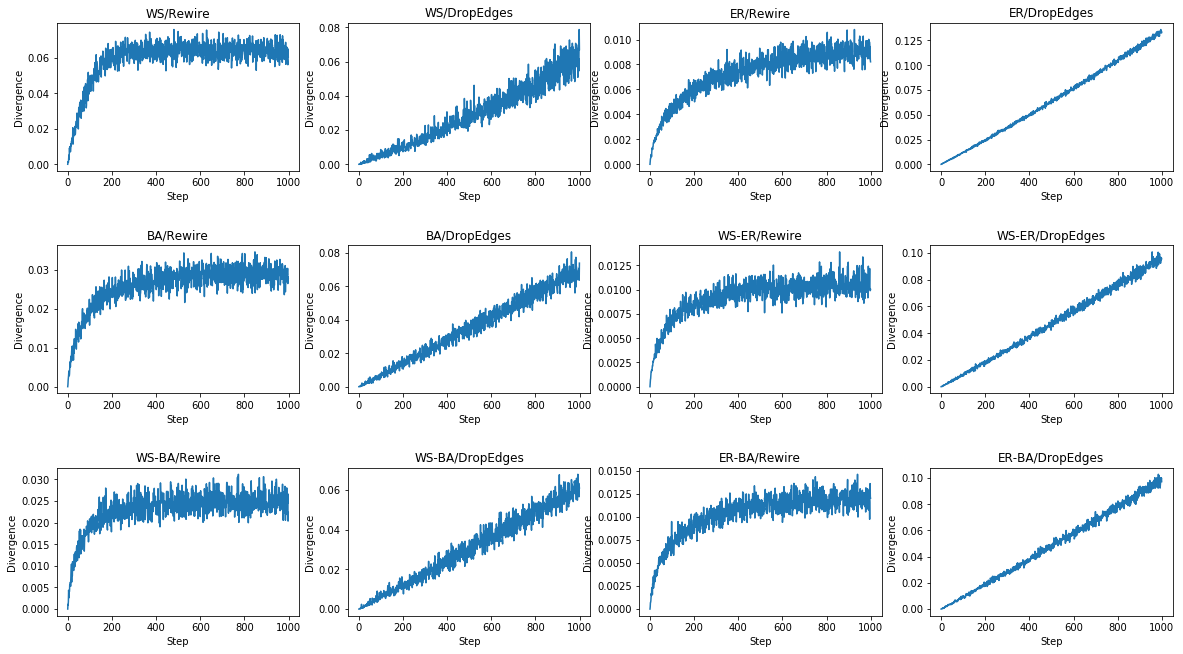

In [7]:
grid_plot(*all_plots)